In [159]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# 7 Assests (Nvidia, Advanced Micro Devices, Gamestop, Walt Disney Co, Pfizer inc, Costco, Target Corp)
tickers =['NVDA','AMD','GME','DIS','PFE','COST','TGT']
etfs=['spy','iwm','dia']

tickers, etfs = [ticker.upper() for ticker in tickers], [
    etf.upper() for etf in etfs
]
# Gathers asset's data from past 10 years (3650 days) to today 
start_date = dt.datetime.today() - pd.Timedelta(3650, "d")
end_date = dt.datetime.today()

#Downloads stock data
tickers_data =yf.download (start=start_date,end=end_date, tickers= tickers + etfs)['Adj Close']
tickers_data.head()

analysis = pd.DataFrame(index=tickers)

#Portfolio Wieght (must be equally weighted!) = 1/7 (since there are seven assests)
analysis['Portfolio Weight']= 100/len(tickers)

[*********************100%%**********************]  10 of 10 completed


In [160]:
daily_returns = tickers_data.pct_change()

# drops row with NaN values: the value of the first row because the numerator = 0 
# when calculating daily returns since there is no data from previous day to calculate for the next day.
daily_returns = daily_returns.drop(index = daily_returns.index[0], axis=0, inplace=False) 
daily_returns

Ticker,AMD,COST,DIA,DIS,GME,IWM,NVDA,PFE,SPY,TGT
Date,,,,,,,,,,
2014-04-21,0.116531,0.005286,0.001710,-0.011001,-0.012057,0.004694,0.008082,0.020165,0.003487,-0.004000
2014-04-22,0.043689,-0.004733,0.004694,0.004298,0.031731,0.010313,0.008551,0.004536,0.004545,0.009371
2014-04-23,-0.011628,0.010832,-0.000971,0.000881,-0.055832,-0.006281,0.011659,-0.002581,-0.002342,0.006963
2014-04-24,0.007059,0.002091,0.000304,0.000881,0.007517,-0.002546,0.008905,-0.006792,0.002027,0.011689
2014-04-25,-0.053738,-0.000174,-0.008136,-0.017088,-0.020890,-0.017604,-0.027518,0.001302,-0.008199,-0.003092
...,...,...,...,...,...,...,...,...,...,...
2024-04-08,-0.003051,-0.002676,0.000617,-0.008701,-0.037333,0.005478,-0.009942,-0.003001,0.000559,-0.012051
2024-04-09,0.005180,0.009525,-0.000668,0.005283,0.016621,0.003940,-0.020417,0.007524,0.001157,0.011373
2024-04-10,-0.021314,0.005553,-0.011136,-0.006612,-0.014532,-0.026408,0.019741,-0.017177,-0.010013,-0.000058


In [161]:
# Column 3: Calculates annualized volatility trailing over 3-months 
volatility_three = daily_returns[tickers][-63:].std() * (252 ** (1/2)) * 100

# Drop NaN values from the trailing window
volatility_three[tickers]
print(volatility_three)
analysis['Annualized Volatility'] = volatility_three

Ticker
NVDA    50.679565
AMD     54.270189
GME     63.094141
DIS     31.423622
PFE     21.211220
COST    21.413186
TGT     32.567072
dtype: float64


source for Columns 4-6: https://www.youtube.com/watch?v=_8DZxoEwpwE

In [162]:
# Slices daily returns to gather data trailing 12 months
daily_returns= daily_returns[-252:] #252 days to 1 year's worth of trading days
daily_returns

#--------------------------------Beta against SPY
covariance = daily_returns.cov()
variance = np.var(daily_returns['SPY'])
beta =[] 

for i in tickers:
    asset_beta = covariance.loc[i,'SPY']/variance
    beta.append(asset_beta)

print('beta vs spy:',beta)
analysis['Beta vs SPY']=beta

#----------------------------------Beta against IWM 
covariance2= daily_returns.cov()
variance2= np.var(daily_returns['IWM'])
beta2 =[] 

for i in tickers:
    asset_beta2 = covariance2.loc[i,'IWM']/variance2
    beta2.append(asset_beta2)
print('beta vs iwm:', beta2)
analysis['Beta vs IWM']=beta2

#----------------------------------Beta against DIA
covariance3= daily_returns.cov()
variance3= np.var(daily_returns['DIA'])
beta3 =[] 

for i in tickers:
    asset_beta3 = covariance3.loc[i,'DIA']/variance3
    beta3.append(asset_beta3)
print('beta vs dia',beta3)
analysis['Beta vs DIA']=beta3

beta vs spy: [2.228774501389158, 2.2269555632678557, 1.573661161417278, 0.8749350302604987, 0.3818476451237814, 0.7836509840084364, 0.7146579775717999]
beta vs iwm: [0.46741576179666383, 0.6886800153333797, 1.3932655493660844, 0.5268141800084245, 0.2322036047047638, 0.254197565852962, 0.5586211176646958]
beta vs dia [1.2271794758348562, 1.432017767221511, 1.6403087714561324, 1.138455720124848, 0.5944131768822918, 0.8062951486936484, 1.059630551276917]


In [163]:
#Columns 7+8: Average and max weekly drawdowns
def drawdowns(values):
        
    # Weekly min and max calculations
    weekly_min = values.rolling(5).min()
    weekly_max = values.rolling(5).max()

    # Weekly drawdown calculations for the latest year
    weekly_dd = ((weekly_min - weekly_max) / weekly_max)[-252:] * 100

    # Calculate mean and max for the latest year
    return weekly_dd.mean(), weekly_dd.min()

analysis['Avg weekly Drawdown'], analysis['Max weekly Drawdown'] = drawdowns(tickers_data)

print(analysis)

      Portfolio Weight  Annualized Volatility  Beta vs SPY  Beta vs IWM  \
NVDA         14.285714              50.679565     2.228775     0.467416   
AMD          14.285714              54.270189     2.226956     0.688680   
GME          14.285714              63.094141     1.573661     1.393266   
DIS          14.285714              31.423622     0.874935     0.526814   
PFE          14.285714              21.211220     0.381848     0.232204   
COST         14.285714              21.413186     0.783651     0.254198   
TGT          14.285714              32.567072     0.714658     0.558621   

      Beta vs DIA  Avg weekly Drawdown  Max weekly Drawdown  
NVDA     1.227179            -5.654493           -23.866265  
AMD      1.432018            -5.998076           -15.881306  
GME      1.640309            -7.668498           -27.225808  
DIS      1.138456            -3.371187           -12.565586  
PFE      0.594413            -3.028105            -9.207786  
COST     0.806295          

In [164]:
#Column9: total returns trailing 10 years
current_price= (tickers_data[tickers].iloc[-1]) # Returns the latest price for each asset 

starting_price= tickers_data[tickers].iloc[0] #returns the starting price for each asset


for i in tickers:
    total_return=(((current_price-starting_price)/starting_price)*100).round(2)
total_return=total_return.dropna() 
   
print(total_return)

#Total Returns
analysis['Total Returns']= total_return

Ticker
NVDA    19955.49
AMD      4324.93
GME        42.97
DIS        55.38
PFE        31.24
COST      698.72
TGT       267.84
dtype: float64


In [165]:
starting_price= tickers_data[tickers].iloc[0] #returns the starting price for each asset
starting_price

for i in tickers:
    total_return=(((current_price-starting_price)/starting_price)*100).round(2)
total_return=total_return.dropna() 
   
print(total_return)

#Total Returns
analysis['Total Returns']= total_return

Ticker
NVDA    19955.49
AMD      4324.93
GME        42.97
DIS        55.38
PFE        31.24
COST      698.72
TGT       267.84
dtype: float64


In [166]:
#Column 10: Annualized Total returns
annual_return = (((1+total_return)**(252/2520)-1)*100).round(2)
print(annual_return)

#Annualized Total Return
analysis['Annualized Total Return']= annual_return

Ticker
NVDA    169.16
AMD     131.00
GME      45.99
DIS      49.66
PFE      41.53
COST     92.53
TGT      74.96
dtype: float64


In [167]:
analysis

,Portfolio Weight,Annualized Volatility,Beta vs SPY,Beta vs IWM,Beta vs DIA,Avg weekly Drawdown,Max weekly Drawdown,Total Returns,Annualized Total Return
NVDA,14.285714,50.679565,2.228775,0.467416,1.227179,-5.654493,-23.866265,19955.49,169.16
AMD,14.285714,54.270189,2.226956,0.688680,1.432018,-5.998076,-15.881306,4324.93,131.00
GME,14.285714,63.094141,1.573661,1.393266,1.640309,-7.668498,-27.225808,42.97,45.99
DIS,14.285714,31.423622,0.874935,0.526814,1.138456,-3.371187,-12.565586,55.38,49.66
PFE,14.285714,21.211220,0.381848,0.232204,0.594413,-3.028105,-9.207786,31.24,41.53
COST,14.285714,21.413186,0.783651,0.254198,0.806295,-2.397764,-9.102714,698.72,92.53
TGT,14.285714,32.567072,0.714658,0.558621,1.059631,-3.582155,-18.982663,267.84,74.96


Table #2

In [168]:
#Column 1: 
tickers_data[etfs]
portfolio_risk=pd.DataFrame(index=etfs)


In [169]:
#Calculates equally weighted portfolio returns 

daily_returns["equal_weight"]= daily_returns[tickers].mean(axis=1) # using axis=1, calculates the mean going across each row
tickers_data["equal_weight"]= tickers_data[tickers].mean(axis=1) 

#Column 2: 1 yr Correlation between ETFs and equally weighted portfolio
portfolio_risk['Correlation']=daily_returns[-252:].corr().equal_weight

#column 3: 1 yr Covarriance between ETFs and equally weighted portfolio
portfolio_risk['Covarriance']= daily_returns[-252:].cov().equal_weight*10000


/var/folders/q9/1h42_3tn705_j_750qfm6dz00000gn/T/ipykernel_45882/850825956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_returns["equal_weight"]= daily_returns[tickers].mean(axis=1) # using axis=1, calculates the mean going across each row


In [170]:
# Gather returns data 10 years
trailing_returns = tickers_data.pct_change()

# Calculate trailing portfolio returns
trailing_portfolio_return = trailing_returns[tickers].mean(axis=1) #axis=1 computes along row-wise

# Gathers trailing returns into ETF 
trailing_etf_returns = trailing_returns[etfs]

# Formula: Tracking error = stan.dev(portfolio returns - benchmark returns)

    #Difference between tickers returns and etf returns
tracking_errors = trailing_etf_returns.sub(trailing_portfolio_return, axis=0)# axis=0 computes alongcolumn-wise

    #Standard deviation of tracking errors 
tracking_errors_std = tracking_errors.std()

# Adds tracking error column to the portfolio_risk dataframe as a percentage
portfolio_risk['Tracking Error'] = tracking_errors_std

In [171]:
#Sharpe ratio
#Riskfree rate: 5.17% over 1 yr
RF=0.0513/252

#Gather 1yr of returns data
trailing_etf_returns= trailing_etf_returns[-252:]

#Volatility
volatility = trailing_etf_returns.std() * (252 ** (1/2))

sharpe_ratio=(trailing_etf_returns.rolling(5).mean()- RF)*5/volatility
sharpe_ratio=sharpe_ratio.mean(axis=0)
portfolio_risk['Sharpe Ratio'] = sharpe_ratio

In [172]:
#Annualized Volatility Spread
etf_volatility = daily_returns[etfs].std() * (252 ** (1/2))
port_volatility = daily_returns['equal_weight'].std() * (252 ** (1/2))
av_spread= port_volatility-etf_volatility
portfolio_risk['Volatility Spread']= av_spread

In [173]:
portfolio_risk

,Correlation,Covarriance,Tracking Error,Sharpe Ratio,Volatility Spread
SPY,0.712096,0.672193,0.012332,0.033771,0.087928
IWM,0.569145,0.915282,0.013117,0.011745,0.006015
DIA,0.555907,0.455621,0.013239,0.020256,0.103265


<Axes: xlabel='Ticker', ylabel='Ticker'>

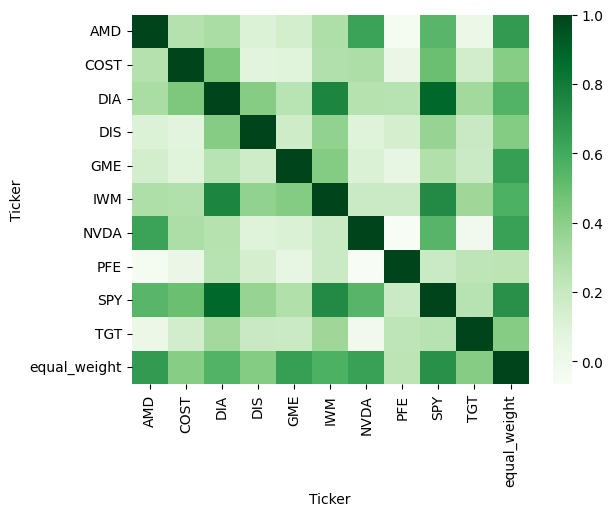

In [174]:
#Correlation Matrix
sns.heatmap(daily_returns[-252:].corr(), cmap= 'Greens')